# Compare Monthly & Daily results

#### Date: 1 March 2024

Author = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

# Setup

#### required packages

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#### start a local Dask client

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37667,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:43249,Total threads: 4
Dashboard: /proxy/38995/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:42001,


#### ignore warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
daily_path = '/g/data/es60/users/thomas_moore/clim_demo_results/daily/'
monthly_path = '/g/data/es60/users/thomas_moore/clim_demo_results/monthly/'

# load and use these NetCDF files

In [11]:
dSTATS = xr.open_mfdataset(daily_path+'BRAN2020_daily_temperature_stats.nc',parallel=True,chunks = {'st_ocean':51, 'yt_ocean':1500, 'xt_ocean':360})
dCLIM = xr.open_mfdataset(daily_path+'BRAN2020_daily_temperature_climatology.nc',parallel=True,chunks = {'month':1,'st_ocean':10, 'yt_ocean':1500, 'xt_ocean':3600})
dQUANT = xr.open_mfdataset(daily_path+'BRAN2020_daily_temperature_quant.nc',parallel=True,chunks = {'quantile':2,'st_ocean':1, 'yt_ocean':1500, 'xt_ocean':3600})

In [12]:
mSTATS = xr.open_mfdataset(monthly_path+'BRAN2020_temperature_stats.nc',parallel=True,chunks = {'st_ocean':51, 'yt_ocean':1500, 'xt_ocean':360})
mCLIM = xr.open_mfdataset(monthly_path+'BRAN2020_temperature_climatology.nc',parallel=True,chunks = {'month':1,'st_ocean':10, 'yt_ocean':1500, 'xt_ocean':3600})
mQUANT = xr.open_mfdataset(monthly_path+'BRAN2020_temperature_quant.nc',parallel=True,chunks = {'quantile':2,'st_ocean':1, 'yt_ocean':1500, 'xt_ocean':3600})

In [13]:
diffSTATS = mSTATS - dSTATS
diffCLIM = mCLIM - dCLIM
diffQUANT = mQUANT - dQUANT

In [14]:
diffQUANT

<xarray.Dataset> Size: 13GB
Dimensions:                (st_ocean: 51, xt_ocean: 3600, yt_ocean: 1500,
                            quantile: 2)
Coordinates:
  * st_ocean               (st_ocean) float64 408B 2.5 7.5 ... 4.509e+03
  * xt_ocean               (xt_ocean) float64 29kB 0.05 0.15 ... 359.9 360.0
  * yt_ocean               (yt_ocean) float64 12kB -74.95 -74.85 ... 74.85 74.95
  * quantile               (quantile) float64 16B 0.05 0.95
Data variables:
    quantile_temp          (quantile, st_ocean, yt_ocean, xt_ocean) float64 4GB dask.array<chunksize=(2, 1, 1500, 3600), meta=np.ndarray>
    El_Nino_quantile_temp  (quantile, st_ocean, yt_ocean, xt_ocean) float64 4GB dask.array<chunksize=(2, 1, 1500, 3600), meta=np.ndarray>
    La_Nina_quantile_temp  (quantile, st_ocean, yt_ocean, xt_ocean) float64 4GB dask.array<chunksize=(2, 1, 1500, 3600), meta=np.ndarray>

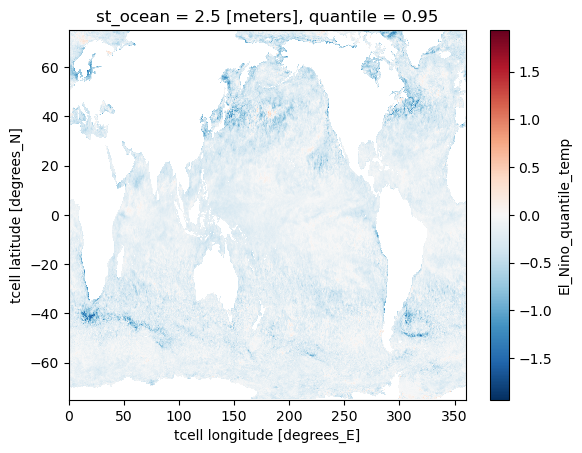

In [15]:
diffQUANT.El_Nino_quantile_temp.isel(st_ocean = 0).isel(quantile=1).plot()

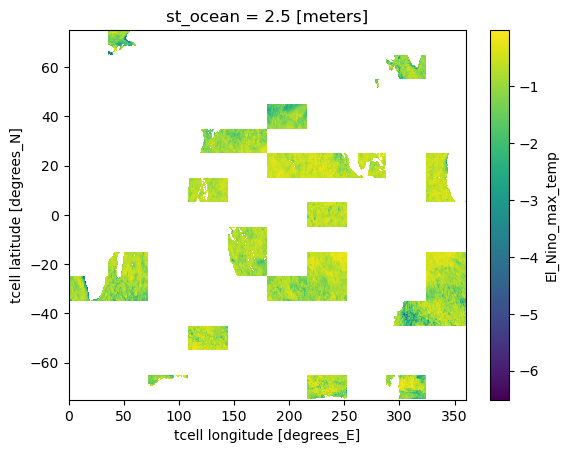

In [16]:
diffSTATS.El_Nino_max_temp.isel(st_ocean = 0).plot()

# The End

In [ ]:
#client.shutdown()

In [10]:
import regionmask

regionmask.__version__

'0.11.0'

In [17]:
# don't expand data
xr.set_options(display_style="text", display_expand_data=False, display_width=60)

In [18]:
lon = np.arange(-179.5, 180)
lat = np.arange(-89.5, 90)

In [19]:
regionmask.defined_regions.srex

<regionmask.Regions 'SREX'>
Source:   Seneviratne et al., 2012 (https://www.ipcc.ch/site/assets/uploads/2...
overlap:  False

Regions:
 1 ALA       Alaska/N.W. Canada
 2 CGI     Canada/Greenl./Icel.
 3 WNA         W. North America
 4 CNA         C. North America
 5 ENA         E. North America
..  ..                      ...
22 EAS                  E. Asia
23 SAS                  S. Asia
24 SEA                S.E. Asia
25 NAU             N. Australia
26 SAU S. Australia/New Zealand

[26 regions]

In [20]:
mask = regionmask.defined_regions.srex.mask_3D(lon, lat)
mask

<xarray.DataArray 'mask' (region: 26, lat: 180, lon: 360)> Size: 2MB
False False False False False ... False False False False
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 ... 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * region   (region) int64 208B 1 2 3 4 5 ... 23 24 25 26
    abbrevs  (region) <U3 312B 'ALA' 'CGI' ... 'NAU' 'SAU'
    names    (region) <U24 2kB 'Alaska/N.W. Canada' ... '...
Attributes:
    standard_name:  region

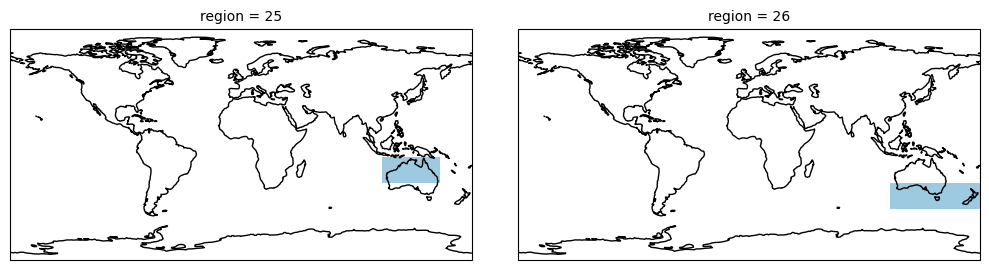

In [27]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colors as mplc

cmap1 = mplc.ListedColormap(["none", "#9ecae1"])

fg = mask.isel(region=slice(24,26)).plot(
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    col="region",
    col_wrap=2,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    aspect=1.5,
    cmap=cmap1,
)

for ax in fg.axes.flatten():
    ax.coastlines()

fg.fig.subplots_adjust(hspace=0, wspace=0.1);

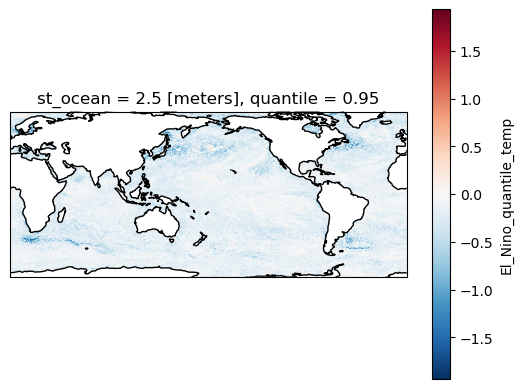

In [29]:
proj = ccrs.PlateCarree(central_longitude=180)

ax = plt.subplot(111, projection=proj)

diffQUANT.El_Nino_quantile_temp.isel(st_ocean = 0).isel(quantile=1).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree())

ax.coastlines();

In [31]:
mask_3D = regionmask.defined_regions.srex.mask_3D(diffQUANT)
mask_3D

KeyError: 'Could not get ``lon`` from ``lon_or_obj``. Please pass lon and lat directlyor try installing cf_xarray.'